# Diabetes Predictions

GOAL: Predict if a person has diabetes or not

*Dataset Link: https://www.kaggle.com/datasets/johndasilva/diabetes/data*

# 1. Setup & Data Preparation

In [79]:
# --------- Core Libraries ---------
import numpy as np
import pandas as pd
import warnings

pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', None)

# --------- Visualization Libraries ---------
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Modelling libraries ---------
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [80]:
# to sync google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
# Read the dataset
df = pd.read_csv('/content/drive/MyDrive/Machine Learning - Projects/Diabetics_prediction/diabetes.csv', low_memory=False)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [82]:
df.shape

(2000, 9)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [84]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [85]:
# Basic statistics on numeric columns
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


# 2. Initial Data Analysis

This section includes:

* Renaming columns as required
* Handling NULL values of important features

## Renaming/Standardizing column names

In [86]:
df = df.rename(columns={'DiabetesPedigreeFunction': 'DPF'})
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


## Handling NULL values

In [87]:
df.isnull().sum()


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DPF,0
Age,0
Outcome,0


Though it is not showing any NULL values because some of the features are filled with 0<br>
Clinically, 0 value for those features doesn't make sense.<br>
Replacing them with NaN

In [88]:
# Replacing 0 values from ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DPF']
df_new = df.copy(deep=True)
df_new[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DPF']] = df_new[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DPF']].replace(0, np.nan)


In [89]:
# Check the NULL values
df_new.isnull().sum()

,0
Pregnancies,0
Glucose,13
BloodPressure,90
SkinThickness,573
Insulin,956
BMI,0
DPF,0
Age,0
Outcome,0


## Imputing values using sklearn

In [90]:
# A function to impute all values at once
def impute_val (df):
  params = {}
  for col in df.columns[df.isnull().any()]:
    if df[col].dtype == 'float64' or df[col].dtype == 'int32' or df[col].dtype == 'int64':
      strategy = 'mean'
    else:
      strategy = 'most_frequent'

    missing_val = df[col][df[col].isnull()].values[0]
    params[col] ={'missing_val': missing_val, 'strategy': strategy}

  return params
impute_val(df_new)


{'Glucose': {'missing_val': np.float64(nan), 'strategy': 'mean'},
 'BloodPressure': {'missing_val': np.float64(nan), 'strategy': 'mean'},
 'SkinThickness': {'missing_val': np.float64(nan), 'strategy': 'mean'},
 'Insulin': {'missing_val': np.float64(nan), 'strategy': 'mean'}}

In [91]:
# call the imputer class
from sklearn.impute import SimpleImputer

parameter = impute_val(df_new)
for col, params in parameter.items():
  missing_val = params['missing_val']
  strategy = params['strategy']

  imp = SimpleImputer(missing_values=missing_val, strategy=strategy)
  df_new[col] = imp.fit_transform(df_new[[col]]).ravel()


In [92]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DPF,0
Age,0
Outcome,0


All the NULL values have been imputed!

# 3. Exploratory Data Analysis
to understand the data

## Age vs diabetic outcome

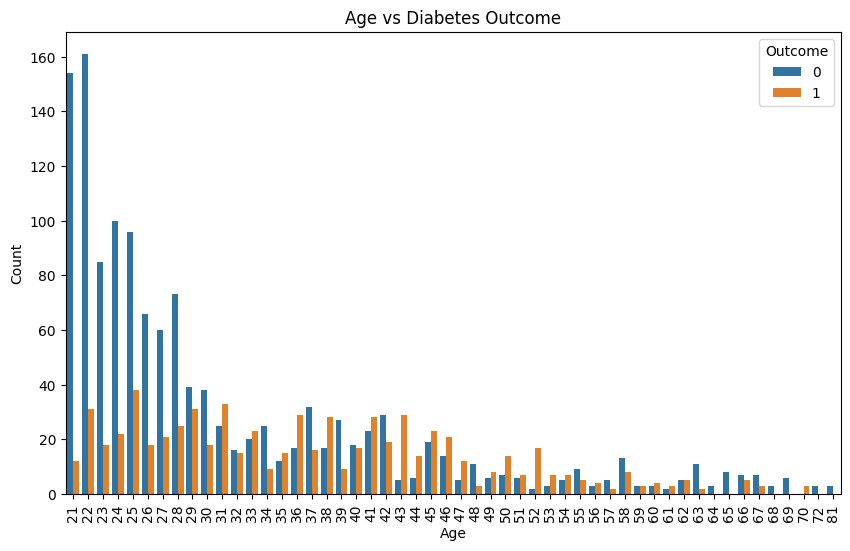

In [93]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Age', hue='Outcome', data=df)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age vs Diabetes Outcome')
plt.xticks(rotation=90)
plt.show()

## Total data entries vs outcomes

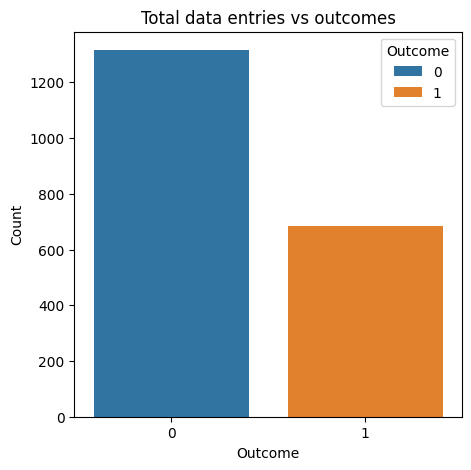

In [94]:
plt.figure(figsize=(5,5))
sns.countplot(x='Outcome', data=df_new, hue='Outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Total data entries vs outcomes')
plt.show()

# 4. Feature engineering & Data splitting

This section incldes <br>
* Handling categorical features
* Splitting dataset for training and testing

In [95]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    2000 non-null   int64  
 1   Glucose        2000 non-null   float64
 2   BloodPressure  2000 non-null   float64
 3   SkinThickness  2000 non-null   float64
 4   Insulin        2000 non-null   float64
 5   BMI            2000 non-null   float64
 6   DPF            2000 non-null   float64
 7   Age            2000 non-null   int64  
 8   Outcome        2000 non-null   int64  
dtypes: float64(6), int64(3)
memory usage: 140.8 KB


All the columns are in numerical format. So no need to convert them from categorical to numerical.

## Data splitting

In [96]:
# split input features and target variable
X = df_new.drop(columns=['Outcome'])
y = df_new['Outcome']


In [97]:
# split train & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [98]:
# train size and test size
print('Train data size: ', X_train.shape, y_train.shape)
print('Test data size', X_test.shape, y_test.shape)

Train data size:  (1600, 8) (1600,)
Test data size (400, 8) (400,)


In [99]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 5. Model implementation

## Using GridSearchCV to find the best algorithm for the model

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# ---------------evaluation metrics---------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [101]:
from sklearn.model_selection import GridSearchCV

def get_best_params(model, param_grid, X_train, y_train, scoring='accuracy'):

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring=scoring,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best CV Score:", grid.best_score_)

    return grid.best_params_

A CV (Cross-Validation) score in machine learning is a performance metric (e.g., accuracy,
, RMSE) calculated by training and testing a model multiple times on different, rotating subsets (folds) of the data. It provides a more reliable, averaged estimate of how well a model generalizes to new, unseen data compared to a single training/testing split.

## MODEL-1: Logistic regression

In [102]:
mdl1 = LogisticRegression()
log_params = {
    'C': [1, 5, 10],
    'solver': ['lbfgs']
}

best_params = get_best_params(mdl1, log_params, X_train, y_train)

mdl1 = LogisticRegression(**best_params)
mdl1.fit(X_train, y_train)


Best Parameters: {'C': 1, 'solver': 'lbfgs'}
Best CV Score: 0.7606250000000001


LogisticRegression(C=1)

## MODEL-2: Random Forest

In [103]:
mdl2 = RandomForestClassifier()

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}

best_params = get_best_params(mdl2, rf_params, X_train, y_train)

mdl2 = RandomForestClassifier(**best_params)
mdl2.fit(X_train, y_train)

Best Parameters: {'max_depth': None, 'n_estimators': 100}
Best CV Score: 0.9506250000000002


RandomForestClassifier()

## MODEL-3: Decision tree

In [104]:
mdl3 = DecisionTreeClassifier()

dc_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5,10]
}

best_params = get_best_params(mdl3, dc_params, X_train, y_train)

mdl3 = DecisionTreeClassifier(**best_params)
mdl3.fit(X_train, y_train)

Best Parameters: {'criterion': 'entropy', 'max_depth': 10}
Best CV Score: 0.915


DecisionTreeClassifier(criterion='entropy', max_depth=10)

## MODEL-4: SVM

In [105]:
mdl4 = SVC()

svm_params ={
    'C': [1,10],
    'kernel': ['rbf','linear']
}

best_params = get_best_params(mdl4, svm_params, X_train, y_train)

mdl4 = SVC(**best_params)
mdl4.fit(X_train, y_train)

Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best CV Score: 0.844375


SVC(C=10)

Among the 4 models trained above, Random Forest has the highest accuracy.

# Model evaluation

In [106]:
# Creating a function to evaluate a model
def model_eval(model_name, y_test, mod_pred):
  accuracy = accuracy_score(y_test, mod_pred)
  precision = precision_score(y_test, mod_pred)
  recall = recall_score(y_test, mod_pred)
  f1 = f1_score(y_test, mod_pred)

  cm = confusion_matrix(y_test, mod_pred)
  print('Confusion matrix: \n', cm)
  # plotting confusion matric
  plt.figure(figsize=(8,5))
  sns.heatmap(cm, annot=True, cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  print('-----RESULTS - : ', model_name, '-----')
  print('Accuracy: ', accuracy)
  print('Precision: ', precision)
  print('Recall: ', recall)
  print('F1 score: ', f1)

  print('Classification report: \n', classification_report(y_test, mod_pred))



In [107]:
mdl2_pred = mdl2.predict(X_test)

Confusion matrix: 
 [[259   5]
 [  2 134]]


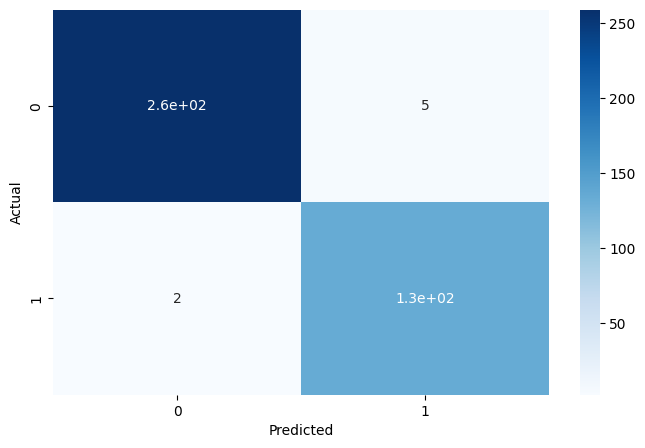

-----RESULTS - :  RANDOM FOREST -----
Accuracy:  0.9825
Precision:  0.9640287769784173
Recall:  0.9852941176470589
F1 score:  0.9745454545454545
Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       264
           1       0.96      0.99      0.97       136

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [108]:
mdl2_metrics = model_eval('RANDOM FOREST', y_test, mdl2_pred)
mdl2_metrics

# Predictions

In [109]:
print(y_train.value_counts())


Outcome
0    1052
1     548
Name: count, dtype: int64


In [110]:
# Creating a function for prediction
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    preg = int(Pregnancies)
    glucose = float(Glucose)
    bp = float(BloodPressure)
    st = float(SkinThickness)
    insulin = float(Insulin)
    bmi = float(BMI)
    dpf = float(DPF)
    age = int(Age)

    x = [[preg, glucose, bp, st, insulin, bmi, dpf, age]]
    x = sc.transform(x)

    return mdl2.predict(x)

In [115]:
# Prediction 1
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(2, 50, 72, 15, 76, 30.1, 0.547, 25)[0]
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [116]:
# Prediction 2
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(1, 117, 88, 24, 145, 34.5, 0.403, 40)[0]
# print('Raw Prediction: ', prediction)
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Oops! You have diabetes.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [117]:
# Prediction 3
# Input sequence: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
prediction = predict_diabetes(5, 120, 92, 10, 81, 26.1, 0.551, 67)[0]
# print('Raw Prediction: ', prediction)
if prediction:
  print('Oops! You have diabetes.')
else:
  print("Great! You don't have diabetes.")

Great! You don't have diabetes.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
